In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout, Activation, MaxPool2D
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.optimizers import Adam
from keras import regularizers
from face_rec import Face_Embedding
from face_rec import Image_Preprocessing
import face_recognition
import pandas as pd
from keras.utils import to_categorical
import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 
from sklearn.model_selection import train_test_split
import os
from itertools import combinations

Using TensorFlow backend.


# GRAY IMAGE MODEL

## input set

In [2]:
%%time
image_folder = './small_traiging_images/'
class_folder = os.listdir(image_folder)
class_dict = {}
equl_list = []
diff_list = []
for folder, f in enumerate(class_folder):
    folder_path = os.path.join(image_folder,f)
    class_images = os.listdir(folder_path)
    print("{}...".format(folder))
    for i, images in enumerate(class_images):
        if '.jpg' in images or '.png' in images:
            img_path = os.path.join(folder_path, images)
            # 랜덤으로 쌍을 만드는데
            pare_image_idx = np.random.randint(len(class_images))
            # 자기자신을 선택하면 다시 선택
            while(pare_image_idx == i):
                pare_image_idx = np.random.randint(len(class_images))
            pare_path = os.path.join(folder_path, class_images[pare_image_idx])
            img1 = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (200,200)).reshape((200,200,-1))
            img2 = cv2.resize(cv2.imread(pare_path, cv2.IMREAD_GRAYSCALE), (200,200)).reshape((200,200,-1))
            pare_folder_idx = np.random.randint(len(class_folder))
            while(pare_folder_idx == folder):
                pare_folder_idx = np.random.randint(len(class_folder))
                
            # 지금 이 폴더 빼고 다른 폴데의 경로를 가지고옴 
            diff_folder_path = os.path.join(image_folder, class_folder[pare_folder_idx])
            # 그 폴더내의 이미지목록을 가지고옴
            diff_iamges = os.listdir(diff_folder_path)
            # 랜덤하게 하나 뽑고
            diff_pare_idx = np.random.randint(len(diff_iamges))
            diff_image_path = os.path.join(diff_folder_path, diff_iamges[diff_pare_idx])
            img3 = cv2.resize(cv2.imread(diff_image_path, cv2.IMREAD_GRAYSCALE), (200,200)).reshape((200,200,-1))
            # 두 이미지를 rgb채널뒤에 얹어서 더함
            # (96,96,6)의 shape으로 만듬
            equl_list.append(np.concatenate((img1, img2), axis = 2))
            diff_list.append(np.concatenate((img1, img3), axis = 2))
#             print("img1 : {} img2 : {} img3 : {}".format(str.split(images, '.')[0],
#                                                          str.split(class_images[pare_image_idx], '.')[0],
#                                                          str.split(diff_iamges[diff_pare_idx], '.')[0]))
            
class_dict[0] = diff_list
class_dict[1] = equl_list

0...
1...
2...
Wall time: 585 ms


In [3]:
print('같은 사진 : {}'.format(len(class_dict[0])))
print('다른 사진 : {}'.format(len(class_dict[1])))

같은 사진 : 60
다른 사진 : 60


In [4]:
class_dict[1][0].shape

(200, 200, 2)

In [5]:
%%time
np_images = np.zeros((1,200,200,2))
for k in class_dict.keys():
    print("{}...".format(k))
    for np_img in class_dict[k]:
        img_ = np_img.reshape((-1,200,200,2))
        np_images = np.append(np_images, img_, axis =0)

0...
1...
Wall time: 1.38 s


In [6]:
np_images = np_images[1:]

In [7]:
label_list = []
for k in class_dict.keys():
    for _ in range(len(class_dict[k])):
        label_list.append(k)

In [8]:
x_data  = np_images
y_data = np.array(label_list)

In [9]:
print(x_data.shape)
print(y_data.shape)

(120, 200, 200, 2)
(120,)


In [10]:
img_size = 200
img_shape = 2
scaler = MinMaxScaler()
# split
x_train, x_val, y_train, y_val = train_test_split(x_data,y_data,test_size = 0.2, random_state = 42)
print("x_train.shape :{}\nx_val.shape : {}".format(x_train.shape, x_val.shape))
print("y_train.shape :{}\ny_val.shape : {}".format(y_train.shape, y_val.shape))

# 데이터 정규화
x_train_norm = x_train[:,:,:,:]
x_val_norm = x_val[:,:,:,:]
x_train_norm = x_train_norm.reshape([-1, img_size*img_size])
x_val_norm = x_val_norm.reshape([-1,img_size*img_size])
print("x_train_norm.shape : {}".format(x_train_norm.shape))
print("x_val_norm,.shape : {}".format(x_val_norm.shape))
x_train_norm = scaler.fit_transform(x_train_norm)
x_val_norm = scaler.fit_transform(x_val_norm)
print("x_train_norm.mean : {}".format(x_train_norm.mean()))
print("x_train_norm.std : {}".format(x_train_norm.std()))
# reshape
x_train_norm = x_train_norm.reshape([-1,img_size,img_size,img_shape])
x_val_norm = x_val_norm.reshape([-1,img_size,img_size,img_shape])
print("x_train_norm.shape : {}".format(x_train_norm.shape))
print("x_val_norm,.shape : {}".format(x_val_norm.shape))
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print("y_train.shape {}, y_val.shape : {}".format(y_train.shape, y_val.shape))

x_train.shape :(96, 200, 200, 2)
x_val.shape : (24, 200, 200, 2)
y_train.shape :(96,)
y_val.shape : (24,)
x_train_norm.shape : (192, 40000)
x_val_norm,.shape : (48, 40000)
x_train_norm.mean : 0.4816275243770613
x_train_norm.std : 0.28118547379762354
x_train_norm.shape : (96, 200, 200, 2)
x_val_norm,.shape : (24, 200, 200, 2)
y_train.shape (96, 2), y_val.shape : (24, 2)


### np, scaler save

In [11]:
# np_path = './not_affine_cnn_np'
# norm_np_path = './not_affine_cnn_norm_np'
# scaler_path = 'not_affine_cnn_scaler.save'
# np.savez(np_path, x_data = x_data, y_data = y_data)
# np.savez(norm_np_path, x_train_norm= x_train_norm, x_val_norm = x_val_norm, y_train = y_train, y_val = y_val)
# joblib.dump(scaler, scaler_path) 

### load np, scaler 

In [12]:
# norm_np_path = './not_affine_cnn_norm_np.npz'
# scaler_path = 'not_affine_cnn_scaler.save'
# scaler = joblib.load(scaler_path) 
# xy_normnp = np.load(norm_np_path)

In [13]:
# x_train_norm = xy_normnp['x_train_norm']
# x_val_norm = xy_normnp['x_val_norm']
# y_train = xy_normnp['y_train']
# y_val = xy_normnp['y_val']
# print("x_train_norm.shape : {} x_val_norm.shape : {} \ny_train.shape : {} y_val.shape : {}"
#       .format(x_train_norm.shape, x_val_norm.shape, y_train.shape, y_val.shape))

## build model

In [14]:
output_class = 2

model = Sequential()
model.add(Conv2D(24, (3,3), input_shape = (200,200,2),  use_bias = False, kernel_initializer='he_normal', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis = -1))
model.add(Activation('relu'))

model.add(Conv2D(18, (2,2), use_bias = False,  kernel_initializer='he_normal', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis = -1))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(13, (2,2), use_bias = False,  kernel_initializer='he_normal', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis = -1))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(62,use_bias  = True, kernel_initializer = 'he_normal',bias_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis = -1))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(48,use_bias  = True, kernel_initializer = 'he_normal',bias_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis = -1))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(output_class ,use_bias  = True, kernel_initializer = 'he_normal',bias_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model.add(BatchNormalization(axis = -1))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [15]:
model.summary(), model.input, model.output

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 24)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 198, 24)      96        
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 24)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 197, 197, 18)      1728      
_________________________________________________________________
batch_normalization_2 (Batch (None, 197, 197, 18)      72        
_________________________________________________________________
activation_2 (Activation)    (None, 197, 197, 18)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 18)        0         
__________

(None,
 <tf.Tensor 'conv2d_1_input:0' shape=(?, 200, 200, 2) dtype=float32>,
 <tf.Tensor 'activation_6/Softmax:0' shape=(?, 2) dtype=float32>)

In [16]:
log = model.fit(x_train_norm, y_train, epochs = 100, batch_size = 4, validation_data= [x_val_norm,y_val])

Train on 96 samples, validate on 24 samples
Epoch 1/100
96/96 [==============================] - 10s 101ms/step - loss: 4.9432 - acc: 0.3958 - val_loss: 5.4313 - val_acc: 0.4583
Epoch 2/100
96/96 [==============================] - 6s 60ms/step - loss: 5.0929 - acc: 0.5938 - val_loss: 4.8933 - val_acc: 0.4583
Epoch 3/100
96/96 [==============================] - 6s 60ms/step - loss: 4.4456 - acc: 0.6146 - val_loss: 4.2659 - val_acc: 0.3333
Epoch 4/100
96/96 [==============================] - 6s 60ms/step - loss: 3.9562 - acc: 0.5417 - val_loss: 3.9217 - val_acc: 0.4583
Epoch 5/100
96/96 [==============================] - 6s 60ms/step - loss: 3.7691 - acc: 0.6667 - val_loss: 3.8752 - val_acc: 0.3750
Epoch 6/100
96/96 [==============================] - 6s 60ms/step - loss: 3.9110 - acc: 0.6562 - val_loss: 4.2176 - val_acc: 0.5417
Epoch 7/100
96/96 [==============================] - 6s 61ms/step - loss: 4.1399 - acc: 0.6354 - val_loss: 4.0243 - val_acc: 0.5000
Epoch 8/100
96/96 [===========

96/96 [==============================] - 6s 60ms/step - loss: 2.4548 - acc: 0.7500 - val_loss: 2.6563 - val_acc: 0.5000
Epoch 63/100
96/96 [==============================] - 6s 60ms/step - loss: 2.2638 - acc: 0.7500 - val_loss: 2.3163 - val_acc: 0.6667
Epoch 64/100
96/96 [==============================] - 6s 60ms/step - loss: 2.2336 - acc: 0.7083 - val_loss: 2.4546 - val_acc: 0.5833
Epoch 65/100
96/96 [==============================] - 6s 60ms/step - loss: 2.3348 - acc: 0.6771 - val_loss: 2.5675 - val_acc: 0.5000
Epoch 66/100
96/96 [==============================] - 6s 60ms/step - loss: 2.8162 - acc: 0.6771 - val_loss: 3.4086 - val_acc: 0.4583
Epoch 67/100
96/96 [==============================] - 6s 60ms/step - loss: 2.9440 - acc: 0.7500 - val_loss: 3.0209 - val_acc: 0.5833
Epoch 68/100
96/96 [==============================] - 6s 60ms/step - loss: 2.4852 - acc: 0.6875 - val_loss: 2.5427 - val_acc: 0.4167
Epoch 69/100
96/96 [==============================] - 6s 60ms/step - loss: 2.2121 

In [17]:
def show_results(*logs):
    trn_loss, val_loss, trn_acc, val_acc = [],[],[],[]
    
    for log in logs:
        trn_loss += log.history['loss']
        val_loss += log.history['val_loss']
        
    fig, ax = plt.subplots(figsize = (8,4))
    # loss value
    ax.plot(trn_loss, label = 'train')
    # accuracy
    ax.plot(val_loss, label = 'validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend()

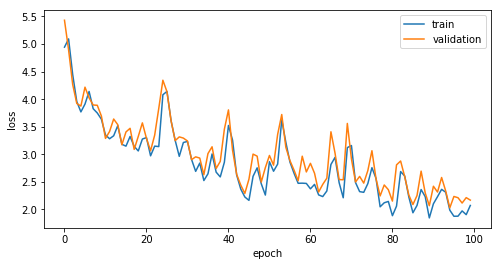

In [18]:
show_results(log)

# AFFINE IAMGE MODEL

In [57]:
def detected_face(face_area, one_image=True):
    # 검출되는 얼굴영역이 여러개 일때는
    # 가장 크게 잡힌 영역을 얼굴로 보도록 함
    if len(face_area) > 1:
        if one_image:
            max_rect_area = [0,0]
            for i, rect in enumerate(face_area):
                rect_area = ((rect.top() - rect.bottom()) * (rect.right()- rect.left()))
                if rect_area > max_rect_area[1]:
                    max_rect_area = [i, rect_area]
    else:
        return [face_area[0]]
    
    return [face_area[max_rect_area[0]]]

# land mark를 포함하는 rect 좌표
# land mark의 범위로 이미지를 잘라내기 위함
def min_max_pos(landmakrs_pos):
    x_list = []
    y_list = []
    for pos in landmakrs_pos:
        x_list.append(pos.x)
        y_list.append(pos.y)
    left_top = (min(x_list)-1, max(y_list)+1)
    right_bottom = (max(x_list)+1, min(y_list)-1)
    return left_top, right_bottom

left : 167 top : 116 right : 322 bottom : 270


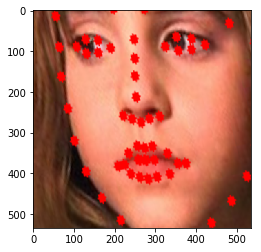

In [58]:
img = cv2.imread('./make_images/emma_10/hermi_1.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# land mark 찍는 model
predictor_model = "./shape_predictor_68_face_landmarks.dat"

face_detector = dlib.get_frontal_face_detector()
face_area = face_detector(gray_img, 1)
# land mark 검출
face_pose_predictor = dlib.shape_predictor(predictor_model)
# affine transformation
face_aligner = openface.AlignDlib(predictor_model)
# 얼굴이 검출 됐을 때
if len(face_area) != 0:
# 얼굴이 검출 됐을때 얼굴이 여러개나오면 가장 큰 영역 얼굴로 사용
    face_rect = detected_face(face_area)
    for fr in face_rect:
        print("left : {} top : {} right : {} bottom : {}".format(fr.left(), fr.top(), fr.right(), fr.bottom()))
        # land mark 찍고(이미지, 검출된 얼굴 rect)
        pose_landmarks = face_pose_predictor(img, fr)
        left_top, right_bottom = min_max_pos(pose_landmarks.parts())
        # land mark 기준으로 얼굴영역 자르
        reduction_img = img[right_bottom[1]:left_top[1], left_top[0]:right_bottom[0]]
        # land mark 찍어줌
        for pos in pose_landmarks.parts():
            cv2.circle(img, (pos.x,pos.y), 3, (0, 0, 255), -1)
        # land mark 통해 얼굴을 앞쪽을 보는 것처럼
        alignedFace = face_aligner.align(534, img, fr, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)

        # plt로 출력하려면 bgr을 rgb로 바꿔줘야함
        alignedFace = cv2.cvtColor(alignedFace, cv2.COLOR_BGR2RGB)
        #alignedFace = cv2.resize(alignedFace, (96,96))
    plt.imshow(alignedFace)    

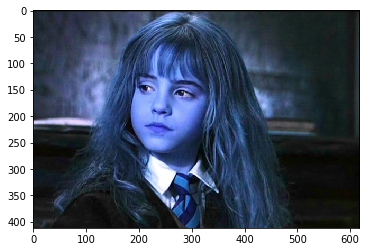

In [60]:
plt.imshow(cv2.imread('./make_images/emma_10/hermi_1.jpg'))

In [ ]:
lefttop(x,y)
rightbottom(x,y)

In [59]:
fr

rectangle(167,116,322,270)

In [30]:
import openface

In [ ]:
face_pose_predictor = dlib.shape_predictor(predictor_model)
# affine transformation
face_aligner = openface.AlignDlib(predictor_model)
# 얼굴이 검출 됐을 때

# 얼굴이 검출 됐을때 얼굴이 여러개나오면 가장 큰 영역 얼굴로 사용
face_rect = detected_face(face_area)

In [64]:
test_imgpath = './make_images/emma_10/'
file_list = os.listdir(test_imgpath)

In [65]:
ip = Image_Preprocessing()

In [66]:
img = ip.face_preprocessing(os.path.join(test_imgpath, file_list[1]))[0]

In [67]:
img = cv2.resize(img, (96,96))

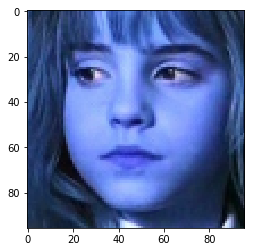

In [68]:
img.shape

In [48]:
face_land = face_recognition.face_landmarks(img)[0]

In [51]:
import dlib

In [53]:
predictor_model = "./shape_predictor_68_face_landmarks.dat"
face_aligner = openface.AlignDlib(predictor_model)

In [72]:
fr

rectangle(167,116,322,270)

In [74]:
dlib.rectangle(left=0, top=96, right=96, bottom=0)

rectangle(0,96,96,0)

In [93]:
alignedFace = face_aligner.align(534, img, dlib.rectangle(left=0, top=0, right=96, bottom=96), landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)

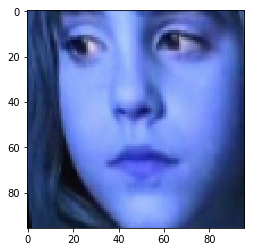

In [96]:
plt.imshow(cv2.resize(alignedFace,(96,96)))

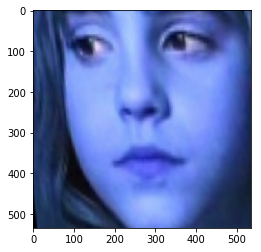

In [94]:
plt.imshow(alignedFace)

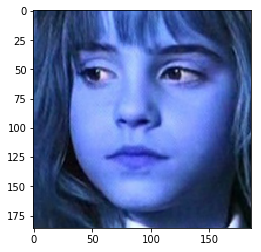

In [44]:
plt.imshow(img)

In [ ]:
ip.face_preprocessing(os.path.join(test_imgpath, file_list[1]))[0]

In [ ]:
face_recognition.face_landmarks

## input set

In [ ]:
%%time
image_folder = './small_traiging_images/'
class_folder = os.listdir(image_folder)
class_dict = {}
equl_list = []
diff_list = []
for folder, f in enumerate(class_folder):
    folder_path = os.path.join(image_folder,f)
    class_images = os.listdir(folder_path)
    print("{}...".format(folder))
    for i, images in enumerate(class_images):
        if '.jpg' in images or '.png' in images:
            img_path = os.path.join(folder_path, images)
            # 랜덤으로 쌍을 만드는데
            pare_image_idx = np.random.randint(len(class_images))
            # 자기자신을 선택하면 다시 선택
            while(pare_image_idx == i):
                pare_image_idx = np.random.randint(len(class_images))
            pare_path = os.path.join(folder_path, class_images[pare_image_idx])
            img1 = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (96,96)).reshape((96,96,-1))
            img2 = cv2.resize(cv2.imread(pare_path, cv2.IMREAD_GRAYSCALE), (96,96)).reshape((96,96,-1))
            pare_folder_idx = np.random.randint(len(class_folder))
            while(pare_folder_idx == folder):
                pare_folder_idx = np.random.randint(len(class_folder))
                
            # 지금 이 폴더 빼고 다른 폴데의 경로를 가지고옴 
            diff_folder_path = os.path.join(image_folder, class_folder[pare_folder_idx])
            # 그 폴더내의 이미지목록을 가지고옴
            diff_iamges = os.listdir(diff_folder_path)
            # 랜덤하게 하나 뽑고
            diff_pare_idx = np.random.randint(len(diff_iamges))
            diff_image_path = os.path.join(diff_folder_path, diff_iamges[diff_pare_idx])
            img3 = cv2.resize(cv2.imread(diff_image_path, cv2.IMREAD_GRAYSCALE), (96,96)).reshape((96,96,-1))
            # 두 이미지를 rgb채널뒤에 얹어서 더함
            # (96,96,6)의 shape으로 만듬
            equl_list.append(np.concatenate((img1, img2), axis = 2))
            diff_list.append(np.concatenate((img1, img3), axis = 2))
#             print("img1 : {} img2 : {} img3 : {}".format(str.split(images, '.')[0],
#                                                          str.split(class_images[pare_image_idx], '.')[0],
#                                                          str.split(diff_iamges[diff_pare_idx], '.')[0]))
            
class_dict[0] = diff_list
class_dict[1] = equl_list

## build model

# GRAY + AFFINE IMAGE MODEL

# 200 * 200 IMAGE MODEL